In [52]:
# Studying the FWHM of the signal vs the FWHM of the input beams
# EOS-BPM Longitudinal resolution study
import copy;
from cycler import cycler;
import matplotlib.pyplot as plt;
import numpy as np;
from scipy import optimize;
from scipy.constants import c;
from scipy.interpolate import interp1d
from scipy.signal import find_peaks;

import sys;
sys.path.insert(0, r'../../python/')
import phase_retard as pr;
import two_beam as tb;

# Colors for plotting.
plot_colors = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', \
               '#DDCC77','#CC6677', '#882255',  '#AA4499'];

cy = cycler('color', plot_colors);


# Bunch parameters
Q_drive    = 1.5e-9;
sigz_drive = 5.2e-6;
sigt_drive = sigz_drive/c;
Q_wit      = 0.5e-9;
sigz_wit   = 5.2e-6;
sigt_wit   = sigz_wit/c;
del_z      = 150e-6;
del_t      = del_z/c;
x_drive    = 3.0e-3;
y_drive    = 0.0;
x_wit      = 3.0e-3;
y_wit      = 0.0;
r_drive    = np.sqrt(x_drive**2 + y_drive**2);
r_wit      = np.sqrt(x_wit**2 + y_wit**2);

drive      = {'Q':Q_drive, 'sig_t':sigt_drive, 'x' : x_drive, 'y' : y_drive};
wit        = {'Q':Q_wit, 'sig_t':sigt_wit, 'x' : x_wit, 'y' : y_wit};

# Crystal parameters (type and thickness)
ctype = 'GaP';
d   = 100e-6;
# Probe parameters
y0      = 800e-9;
a_laser = 0 * np.pi / 180;
z_match = 0;
tau     = np.linspace(-200, 800, 5000) * 1e-15;
probe = {'y0'     :y0, 
         'a_laser': a_laser, 
         'z_match': z_match, 
         'chirp'  : True,
         'width'  : 27e-9};

# time array for THz field
N         = 8000;
dt        = drive['sig_t']/10;
t         = np.linspace(- N * dt/2, N * dt/2, N);

# Compuatational parameters
nslice = int(d * 1e6);
base_params  = {'ctype'    : ctype, 
                't'       : t, 
                'tau'     : tau,
                'nslice'  : nslice,
                'beam1'   : drive,
                'beam2'   : wit,
                't_off'   : del_t,
                'plot'    : False,
                'verbose' : False, 
                'pockel'  : True, 
                'ref'     : True,
                'save'    : False,
                'probe'   : probe}; 
# Functions
# Function for quick plotting 
def makefig():
    fig = plt.figure(figsize = (8,6), dpi = 200);
    ax  = fig.gca();
    ax.set_prop_cycle(cy);
    ax.tick_params(labelsize = 'large')
    return fig, ax;

# Get probe_pulse intensity vs time:
def get_probe(tau):
    del_y = probe['width'];
    # Down-chirp (frequency decreases in time)
    y1    = y0 - (del_y / 2);
    y2    = y0 + (del_y/2);
    f0    = c / y0;
    # in Hz
    f1    = c / y1;
    f2    = c/y2;
    # chirp parameter
    T = abs(tau[0] - tau[-1])
    k = (f2 - f1) / T;
    b = np.pi * k;
    a = (2 * np.log(2)) / T**2;
    gm = a + 1j * b;
    E_probe = np.exp(-gm * tau**2) * np.exp(-1j * 2 * np.pi * f0 * tau);
    I_probe = np.absolute(E_probe)**2;
    return I_probe;
# Get peaks of signal
def get_peaks(signal):
    max_sig = max(signal);
    # Start cutoff at 5 percent the max signal
    cutoff = 0.05
    peaks = find_peaks(signal, height = cutoff * max_sig)[0];
    npeaks = len(peaks);
    while len(peaks) > 2:
        cutoff = cutoff + 0.025
        # sometimes the 2nd peak repeats
        peaks = find_peaks(signal, height = cutoff * max_sig)[0];
        if len(peaks) == 1: #npeaks and len(peaks) == 3:
            cutoff = cutoff - 0.025
            peaks = find_peaks(signal, height = cutoff * max_sig)[0];
            peaks = [peaks[0], peaks[1]];
            break;
        npeaks == len(peaks);
    return peaks;

def get_tenper(signal, peak):
    # Gets range of array around 10% of the peak
    # Signal: the signal array
    # peak:  the index of the peak
    
    max_sig = signal[peak];
    tenper  = 0.1 * max_sig;
    
    if max_sig == max(signal): # drive
        ind1    = np.argmin(abs(signal - tenper));
        if ind1 > peak:
            
            sig = max_sig
            i   = peak;
            while sig > tenper:
                i -= 1;
                sig = signal[i];
            ind1 = i;
    else:
        sig = max_sig;
        i   = peak;
        while sig > tenper:
            i -= 1;
            sig = signal[i];
        ind1 = i;
    ind2    = np.argmin(abs(signal[peak:-1] - tenper)) + peak;
    return ind1, ind2;
def get_fwhm(t, signal, r1, r2):
    f  = interp1d(t, signal);
    hm = max(signal) / 2;
    f2 = lambda t: f(t) - hm
    root1 = optimize.newton(f2, r1)
    root2 = optimize.newton(f2, r2);
    return root1, root2, abs(root1 - root2);


In [45]:
# Loop through several sig_z get fwhm for each one (drive beam)
params = copy.deepcopy(base_params)
params['d'] = 100e-6;
params['plot'] = False;
params['det'] = 'cross';
per_off = np.arange(-50, 51, 10) / 100;
sig_z = 5.2e-6; # m, nominal

drive_fwhm     = np.zeros(len(per_off));
drive_sig_fwhm = np.zeros(len(per_off));
# Once for the drive
plot = False;
for i in range(len(per_off)):
    
    per = per_off[i];
    sz  = sig_z * (1 + per);
    st  = sz / c;
    drive_fwhm[i] = 2 * np.sqrt(2*np.log(2)) * sz * 1e6; # microns
    params['beam1']['sig_t'] = st;
    dummy, dummy, gamma, t_plot = pr.phase_retard(params);
    I_probe            = get_probe(t_plot * 1e-15);
    signal             = I_probe * np.sin(gamma / 2)**2;
    signal             = signal / max(signal);
    peaks              = get_peaks(signal)
    ind1, ind2         = get_tenper(signal, peaks[0]);
    #print(ind1, ind2)
    signal             = signal[ind1:ind2+1]
    t_sig              = t_plot[ind1:ind2+1];
    root1, root2, fwhm = get_fwhm(t_sig, signal, -50, 30);
    drive_sig_fwhm[i]  = (fwhm * 1e-15) * c * 1e6
    print(str(i+1) + "/" + str(len(per_off)), drive_fwhm[i], drive_sig_fwhm[i])
    

0/11 6.1225321170804685 19.435803798734646
1/11 7.347038540496563 19.804121449648314
2/11 8.571544963912656 20.53828524079037
3/11 9.796051387328749 21.082447792487628
4/11 11.020557810744842 21.640344162297364
5/11 12.245064234160937 22.184721185453796
6/11 13.46957065757703 22.705473845271317
7/11 14.694077080993125 23.219204481032886
8/11 15.918583504409218 23.730971421883183
9/11 17.14308992782531 24.25219392120117
10/11 18.367596351241403 24.7872420671284


In [46]:
st  = sz / c;
drive_fwhm[i] = 2 * np.sqrt(2*np.log(2)) * sz * 1e6; # microns
params['beam1']['sig_t'] = st;
dummy, dummy, gamma, t_plot = pr.phase_retard(params);
I_probe            = get_probe(t_plot * 1e-15);
signal = I_probe * np.sin(gamma / 2)**2;


In [48]:
# Loop through several sig_z get fwhm for each one (witness beam)
params = copy.deepcopy(base_params)
params['d'] = 100e-6;
params['plot'] = False;
params['det'] = 'cross';
per_off = np.arange(-50, 51, 10) / 100;
sig_z = 5.2e-6; # m, nominal

wit_fwhm     = np.zeros(len(per_off));
wit_sig_fwhm = np.zeros(len(per_off));
for i in range(len(per_off)):

    per = per_off[i];
    sz  = sig_z * (1 + per);
    st  = sz / c;
    wit_fwhm[i] = 2 * np.sqrt(2*np.log(2)) * sz * 1e6; # microns
    params['beam2']['sig_t'] = st;
    dummy, dummy, gamma, t_plot = pr.phase_retard(params);
    I_probe            = get_probe(t_plot * 1e-15);
    signal             = I_probe * np.sin(gamma / 2)**2;
    signal             = signal / max(signal);
    peaks              = get_peaks(signal)
    ind1, ind2         = get_tenper(signal, peaks[1]);
    signal             = signal[ind1:ind2+1]
    t_sig              = t_plot[ind1:ind2+1];
    root1, root2, fwhm = get_fwhm(t_sig, signal, 440, 520);
    wit_sig_fwhm[i]  = (fwhm * 1e-15) * c * 1e6
    print(str(i+1) + "/" + str(len(per_off)), wit_fwhm[i], wit_sig_fwhm[i])

0/11 6.1225321170804685 26.326459296532782
1/11 7.347038540496563 26.00770330441542
2/11 8.571544963912656 25.750077712425526
3/11 9.796051387328749 25.46797419499314
4/11 11.020557810744842 24.915762550655348
5/11 12.245064234160937 24.3733962695992
6/11 13.46957065757703 23.8367000711343
7/11 14.694077080993125 23.311127597453943
8/11 15.918583504409218 22.79134353467606
9/11 17.14308992782531 22.282948192213894
10/11 18.367596351241403 21.78912566886274


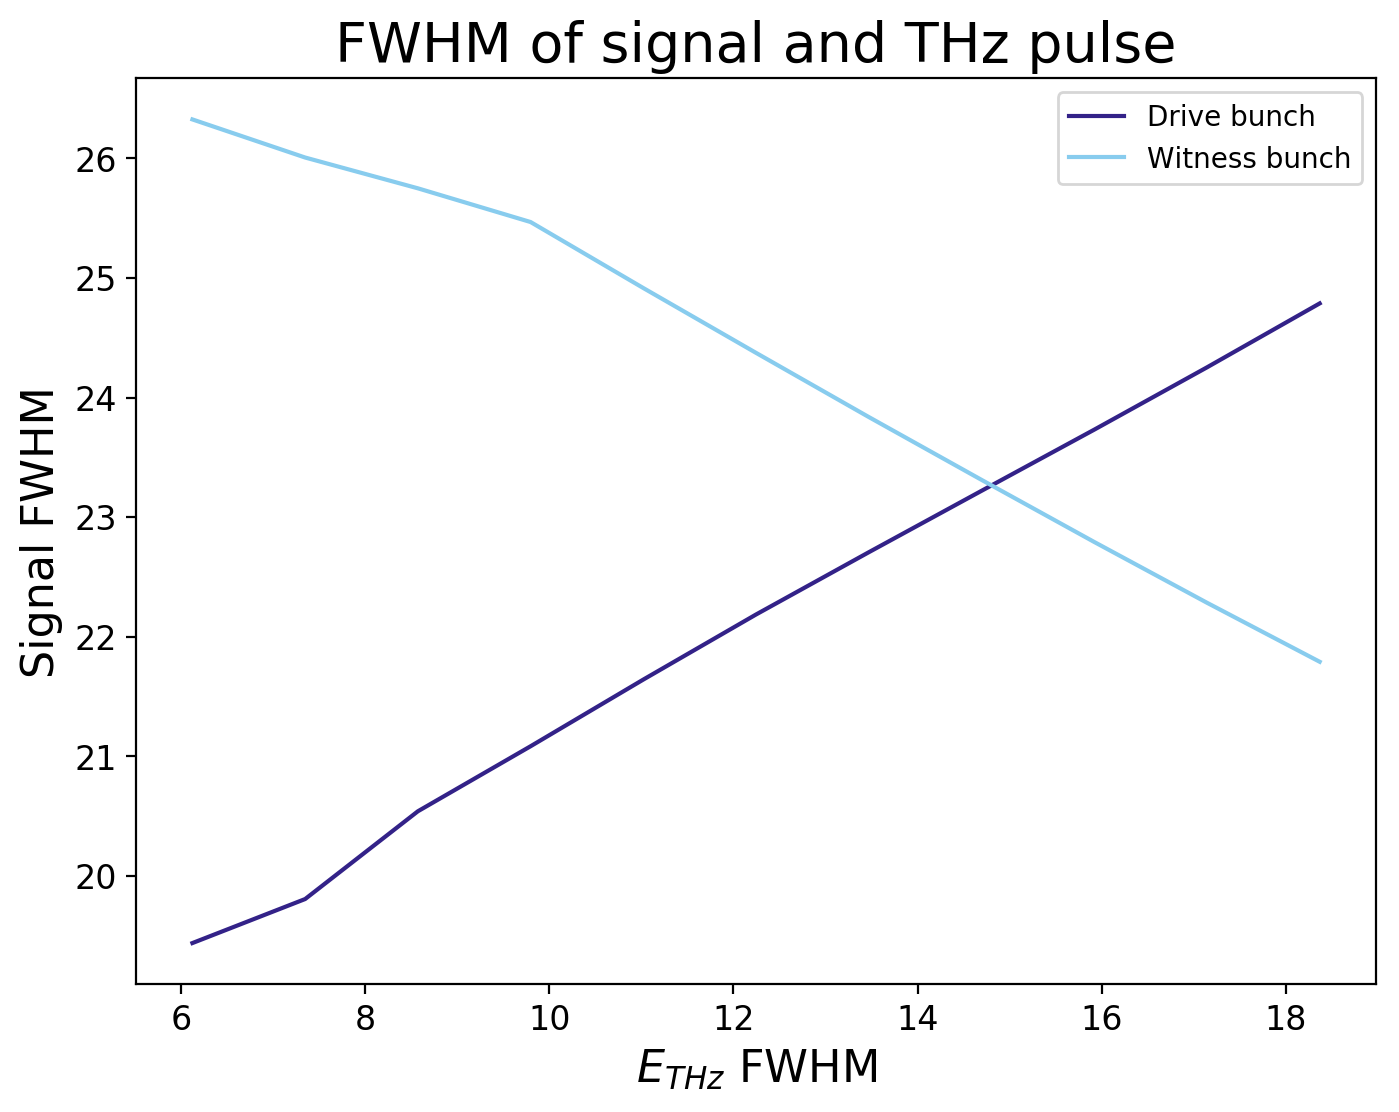

In [53]:
fig, ax = makefig();
fs = 16;
ts = 20;
ax.set_xlabel(r'$E_{THz}$ FWHM', fontsize = fs)
ax.set_ylabel('Signal FWHM', fontsize = fs);
ax.plot(drive_fwhm, drive_sig_fwhm, label = 'Drive bunch');
ax.plot(wit_fwhm, wit_sig_fwhm, label = 'Witness bunch');
ax.set_title("FWHM of signal and THz pulse", fontsize = ts)
ax.legend()
plt.show()

In [38]:
drive_fwhm

array([ 6.12253212,  7.34703854,  8.57154496,  9.79605139, 11.02055781,
       12.24506423, 13.46957066, 14.69407708, 15.9185835 , 17.14308993,
       18.36759635])

In [43]:
drive_inc     = np.zeros(len(drive_fwhm)-1);
drive_sig_inc = np.zeros(len(drive_fwhm)-1);
wit_inc       = np.zeros(len(drive_fwhm)-1);
wit_sig_inc   = np.zeros(len(drive_fwhm)-1);
for i in range(len(drive_fwhm)-1):
    drive_inc[i]     = 1 - drive_fwhm[i] / drive_fwhm[i+1];
    drive_sig_inc[i] = 1 - drive_sig_fwhm[i] / drive_sig_fwhm[i+1];
    wit_inc[i]       = 1 - wit_fwhm[i] / wit_fwhm[i+1];
    wit_sig_inc[i]   = 1 - wit_sig_fwhm[i] / wit_sig_fwhm[i+1];
    print(drive_inc[i], drive_sig_inc[i], wit_inc[i], wit_sig_inc[i])
    

0.16666666666666674 0.018598030306474778 0.16666666666666674 -0.012256214567906376
0.1428571428571428 0.035746109401770254 0.1428571428571428 -0.010004847164619468
0.125 0.02581116562238861 0.125 -0.011076794537032475
0.11111111111111105 0.025780383418380404 0.11111111111111105 -0.022163144443807736
0.10000000000000009 0.02453837569585382 0.10000000000000009 -0.022252388426172498
0.09090909090909083 0.022935115266311645 0.09090909090909083 -0.022515541029726194
0.08333333333333337 0.022125247063534026 0.08333333333333337 -0.022545991028668944
0.07692307692307687 0.021565359957341546 0.07692307692307687 -0.02280620543440337
0.0714285714285714 0.02149176693092225 0.0714285714285714 -0.02281544336398933
0.06666666666666654 0.021585626366911748 0.06666666666666654 -0.022663714499422838
